In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

In [2]:
#Standard modules
import os
import time
import random

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

# Check avaibale device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(DEVICE))

Device: cpu


### Reproductability

In [3]:
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Parameters

In [111]:
#Dataset
DATASET = "FMNIST" 
REDUCED = "tiny"

#Collaborative learning
N_CLIENTS = 4
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.

#Learning
BATCH_SIZE = 64
ROUNDS = 100
EPOCHS_PER_ROUND = 1
LR=1e-2
LAMBDA = 1
CRITERION = nn.CrossEntropyLoss()
CRITERION_DISC = hlp.DiscLoss()
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)

### Data loadiing

** Using FMNIST **
Load train data...
Load validation data...
Dataset sizes:
	- Train: (400, 1, 28, 28)
	- Validation (100, 1, 28, 28)


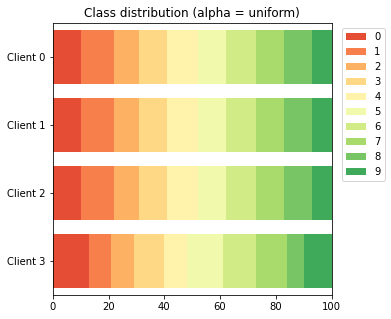

In [112]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET,
                                                                       reduced=REDUCED,
                                                                       device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list)


#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

### Traditional (spearated) learning

Client 0: epoch 100/100 done (Training time: 0.1s, Evaluation time: 0.0s).  
Client 0 done. (10.3s)
Client 1: epoch 100/100 done (Training time: 0.1s, Evaluation time: 0.0s).  
Client 1 done. (9.5s)
Client 2: epoch 100/100 done (Training time: 0.1s, Evaluation time: 0.0s).  
Client 2 done. (9.7s)
Client 3: epoch 100/100 done (Training time: 0.1s, Evaluation time: 0.0s).  
Client 3 done. (10.1s)


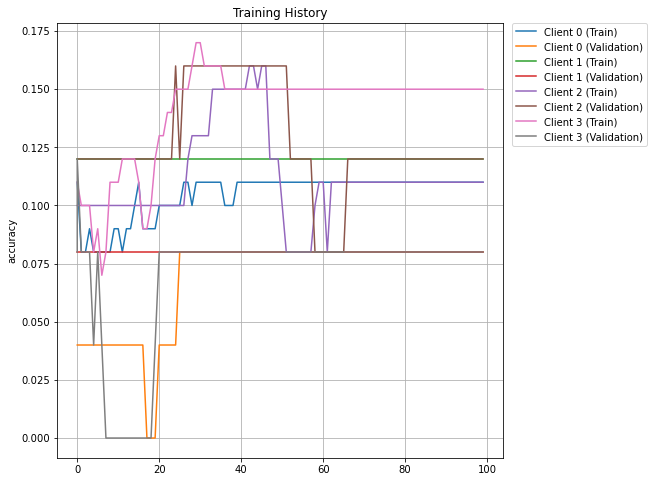

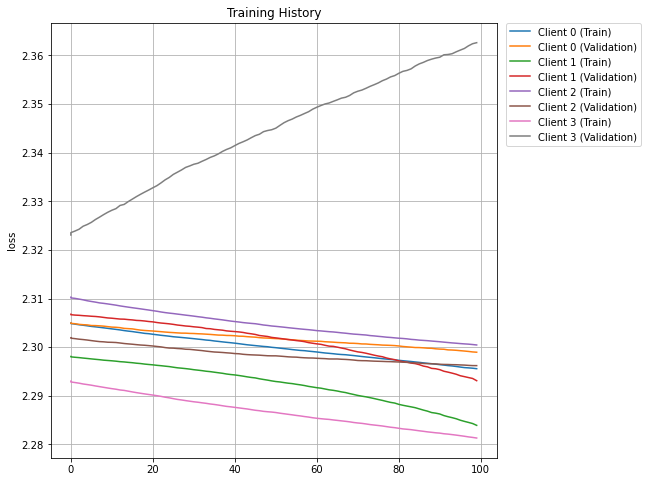

In [113]:
# Model initialization
client_models = [mdl.get_model(DATASET).to(DEVICE) for _ in range(N_CLIENTS)]
    
# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                 CRITERION, meta["n_class"], ID="Client {}".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers = [torch.optim.SGD(m.parameters(), lr=LR) for m in client_models]

#Each client updates its model independently on its own dataset
for client_id in range(N_CLIENTS):
    #Setting up the local training
    model = client_models[client_id]
    model.train()
    optimizer = optimizers[client_id]
    
    #Local update
    t_tot = 0
    for e in range(ROUNDS*EPOCHS_PER_ROUND):
        t0 = time.time()
        for inputs, target in train_dl_list[client_id]:
            optimizer.zero_grad()
            logits = model(inputs)
            loss = CRITERION(logits, target)
            loss.backward()
            optimizer.step()
        t1 = time.time()
        
        #Tracking performance
        if e % N_EVAL == 0:
            perf_trackers[client_id].new_eval(index=e)
        t2 = time.time()
        print("\rClient {}: epoch {}/{} done (Training time: {:.1f}s, Evaluation time: {:.1f}s).".format(client_id, e+1, ROUNDS*EPOCHS_PER_ROUND, t1-t0, t2-t1), end="  ")
        t_tot += t2-t0
    print("\nClient {} done. ({:.1f}s)".format(client_id, t_tot))    

# Plot training history
hlp.plot_global_training_history(perf_trackers, metric="accuracy")
hlp.plot_global_training_history(perf_trackers, metric="loss")

### Learning with private KD

Round 100 done. (0.5s)          

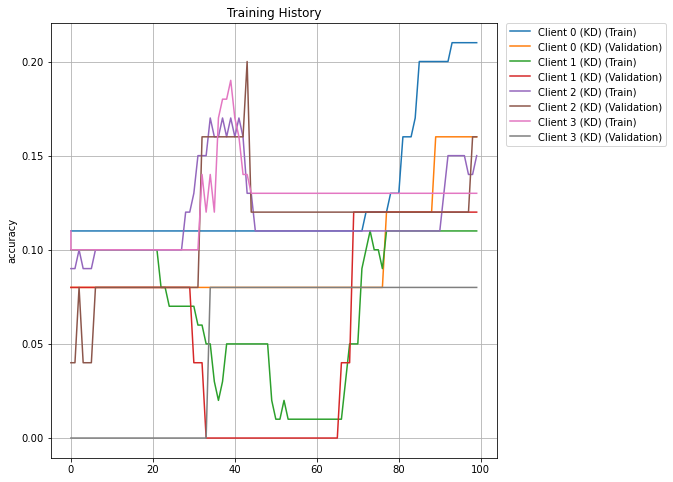

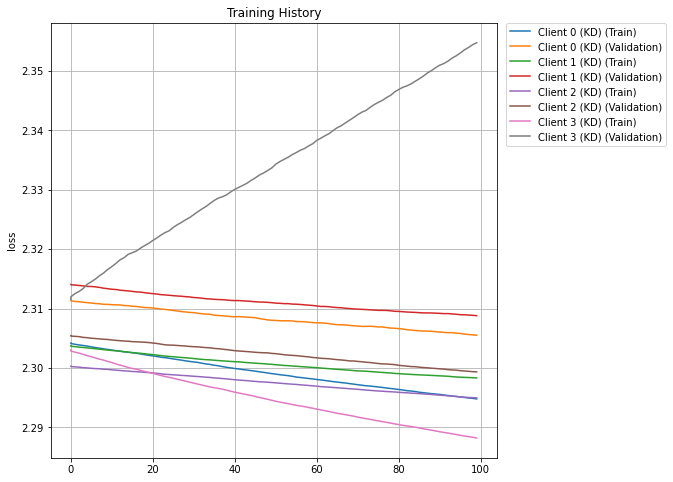

In [114]:
# Model initialization
client_models_kd = [mdl.get_model(DATASET).to(DEVICE) for _ in range(N_CLIENTS)]
meta["feat_dim"] = client_models_kd[0].classifier.in_features

# Performance tracker
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i]}, 
                                    CRITERION, meta["n_class"], ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers_kd = [torch.optim.SGD(m.parameters(), lr=LR) for m in client_models_kd]

# Feature tracker
feat_tracker_kd = hlp.FeatureTracker(client_models, train_ds_list, meta)


#Each client updates its model locally on its own dataset (Standard)
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models_kd[client_id]
        model.train()
        optimizer = optimizers_kd[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, targets in train_dl_list[client_id]:
                # Reset gradient
                optimizer.zero_grad()
                
                # Local representation
                features = model.features(inputs)
                logits = model.classifier(features)
                
                # Compute estimated probabilities
                prob = F.softmax(logits, dim=1)
                logits_global = model.classifier(feat_tracker_kd.get_global_features())
                prob_global = F.softmax(logits_global, dim=1)
                
                # Optimization step
                if LAMBDA:
                    loss = CRITERION(logits, targets) + LAMBDA*CRITERION_DISC(prob, prob_global, targets, torch.arange(10))
                else:
                    loss = CRITERION(logits, targets)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r)      
        
        # Compute representations
        feat_tracker_kd.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")  

# Plot training history
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy")
hlp.plot_global_training_history(perf_trackers_kd, metric="loss")

### Convert to executable

In [14]:
# Convert to executable (without the Magic cells)
#!jupyter nbconvert \
#    --TagRemovePreprocessor.enabled=True \
#    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
#    --TemplateExporter.exclude_markdown=True \
#    --to python "BlindLearning.ipynb"


[NbConvertApp] Converting notebook BlindLearning.ipynb to python
[NbConvertApp] Writing 10602 bytes to BlindLearning.py


In [16]:
from sklearn.manifold import TSNE
user = 0
embedder =  TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)

feat_emb = embedder.fit_transform(torch.cat((features_history[-1][user], features_global[-1])).numpy())

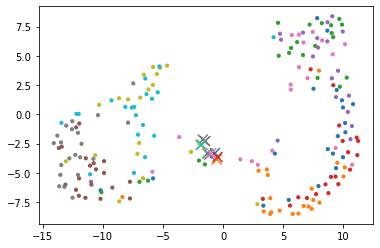

In [17]:
plt.scatter(feat_emb[:-10,0], feat_emb[:-10,1], c=train_ds_list[user].targets, s=10, cmap="tab10")
plt.scatter(feat_emb[-10:,0], feat_emb[-10:,1], marker="x", c=range(10), s=100, cmap="tab10")

In [90]:
class FeatureTracker():
    """Track the feature of each clients for learning/analysis/visualization."""
    def __init__(self, client_models, train_ds_list, meta):
        # Models and datasets
        self.client_models = client_models
        self.train_ds_list = train_ds_list
        self.n_clients = len(client_models)
        self.meta = meta
        
        # Buffers to store features at each round
        self.buffers = [[] for _ in range(self.n_clients)]
        self.average_features = [[] for _ in range(self.n_clients)]
        self.global_features = []
        
        # Class counts
        self.class_counts = torch.zeros(self.n_clients, self.meta["n_class"]).to(int)
        for client_id, class_count in enumerate(self.class_counts):
            val, counts = self.train_ds_list[client_id].targets.unique(return_counts=True)
            self.class_counts[client_id, val] = counts

        # Initialization
        with torch.no_grad():
            for client_id, (model, tr_ds) in enumerate(zip(self.client_models, self.train_ds_list)):
                model.eval()
                features = model.features(tr_ds.inputs)
                average_features = torch.zeros(self.meta["n_class"], self.meta["feat_dim"])
                for c in range(self.meta["n_class"]):
                    average_features[c] = features[tr_ds.targets == c].mean(dim=0)
                self.buffers[client_id].append(features)
                self.average_features[client_id].append(average_features)
            
            # Compute global averaged
            global_features = torch.stack([self.average_features[i][0] * self.class_counts[i].unsqueeze(1) for i in range(self.n_clients)], dim=0).sum(dim=0).div(self.class_counts.sum(dim=0).unsqueeze(1))
            self.global_features.append(global_features)
        
    def new_round(self):
        """Compute the features for each data sample and aggregates the results for the next rounds."""
        # Compute features and averegage
        with torch.no_grad():
            for client_id, (model, tr_ds) in enumerate(zip(self.client_models, self.train_ds_list)):
                model.eval()
                features = model.features(tr_ds.inputs)
                average_features = torch.zeros(self.meta["n_class"], self.meta["feat_dim"])
                for c in range(self.meta["n_class"]):
                    average_features[c] = features[tr_ds.targets == c].mean(dim=0)
                self.buffers[client_id].append(features)
                self.average_features[client_id].append(average_features)
            
            # Compute global averaged
            global_features = torch.stack([self.average_features[i][0] * self.class_counts[i].unsqueeze(1) for i in range(self.n_clients)], dim=0).sum(dim=0).div(self.class_counts.sum(dim=0).unsqueeze(1))
            self.global_features.append(global_features)
    
    def get_global_features(r=-1):
        """Return the global aggregated feature at the given round."""
        return self.global_features[r]

        

In [93]:
featTracker = FeatureTracker(client_models, train_ds_list, meta)
featTracker.new_round()

In [94]:
featTracker.global_features[0].shape

torch.Size([10, 84])

In [96]:
featTracker.average_features[3][1].shape

torch.Size([10, 84])

In [98]:
featTracker.buffers[2][1].shape

torch.Size([500, 84])